<a href="https://colab.research.google.com/github/Sergiodiaz53/AI-HaematologicalDiseases/blob/main/Autolabeller_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Packages
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import nltk
import random
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

#Tools
from google.colab import drive
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 876559196189433030]

In [ ]:
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')

#Spanish stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))

#mount Drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [ ]:
CBC_file_dir = root_dir + "Data/ProcessedData-2021-Filtrados-Observaciones.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))
print(CBC.sample(n=1))

File loaded, shape:(4061, 19)
        Edad  ...                                      Observaciones
85  0.784314  ...  FORMULA REVISADA. SIN ALTERACONES MORFOLOGICAS...

[1 rows x 19 columns]


In [ ]:
# Coge las filas de CBC donde CLASE sea igual a 0, 1, 2 o 3

healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
hemog = CBC.loc[CBC['Clase'] == 2]
anemias_ferro = CBC.loc[CBC['Clase'] == 3]
anemias_trans = CBC.loc[CBC['Clase'] == 4]

num_max_samples = min(len(healthy),len(thalassemias),len(hemog),len(anemias_ferro), len(anemias_trans))
print('Sample limit: ', num_max_samples)

healthy = healthy.sample(n=num_max_samples)
thalassemias = thalassemias.sample(n=num_max_samples)
hemog = hemog.sample(n=num_max_samples)
anemias_ferro = anemias_ferro.sample(n=num_max_samples)
anemias_trans = anemias_trans.sample(n=num_max_samples)

CBC = pd.concat([healthy, thalassemias, hemog, anemias_ferro, anemias_trans],ignore_index=True)

# Dropear observaciones vacias y clases vacias

CBC = CBC.dropna(axis=0, how='any', subset=['Observaciones'])
CBC = CBC.dropna(axis=0, how='any', subset=['Clase'])

print(CBC.Clase.value_counts())
print(CBC.sample(1))


Sample limit:  455
4.0    455
3.0    455
2.0    455
1.0    455
0.0    455
Name: Clase, dtype: int64
         Edad  ...                                      Observaciones
1947  0.77451  ...  FORMULA REVISADA, CON DISCRETO REFUERZO DE LA ...

[1 rows x 19 columns]


In [ ]:
# Quedarse con las observaciones y las etiquetas

CBC = CBC[['Observaciones', 'Clase']]

print(len(CBC))
print(CBC.sample(1))

2275
                                          Observaciones  Clase
1470  FORMULA REVISADA CON DISCRETAS ALTERACIONES DE...    3.0


In [ ]:
def normalizeDataset(dataset):
  """Given a dataset with a description field, normalize the text 
  keeping only words in lowercase without symbols, numbers or stopwords

  Example: 'this is an 1234 important text =)' ---> [[THIS],[IMPORTANT],[TEXT]]
  """
  normalizedCBC = []

  for idx, sample in enumerate(CBC['Observaciones']):
    auxCBC = sample.split()
    auxRow = []
    for idx_2, token in enumerate(auxCBC):
      normalized_token = ''.join(e for e in token if e.isalpha()).lower()
      if not normalized_token in STOPWORDS:
        if (len(normalized_token)>1):
          auxRow.append(normalized_token)
    normalizedCBC.append(auxRow)

  dataset['Observaciones'] = normalizedCBC
  return dataset

CBC = normalizeDataset(CBC)

In [ ]:
def generateVocabulary(dataset):
    vocab = []
    for observation in dataset['Observaciones']:
        for word in observation:
            vocab.append(word)
    return vocab

vocabulary = generateVocabulary(CBC)
vocabulary = set(vocabulary)
print(len(vocabulary))

vocab_size = int(round(len(vocabulary)/2))
oov_token = 'oov'
CBC_labels = CBC['Clase']
CBC_samples = CBC['Observaciones']

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(CBC_samples)
word_index = tokenizer.word_index
print(word_index)

1234
{'oov': 1, 'alfa': 2, 'revisada': 3, 'talasemia': 4, 'plaquetas': 5, 'formula': 6, 'alteraciones': 7, 'comprobadas': 8, 'alelo': 9, 'sr': 10, 'morfologicas': 11, 'significativas': 12, 'gen': 13, 'normal': 14, 'anemia': 15, 'impresiona': 16, 'serie': 17, 'presenta': 18, 'roja': 19, 'cadena': 20, 'descarta': 21, 'morfologia': 22, 'determina': 23, 'microcitica': 24, 'hemoglobinopatia': 25, 'asociada': 26, 'mutacion': 27, 'normocromica': 28, 'normocitica': 29, 'mutado': 30, 'hipocroma': 31, 'heterocigota': 32, 'exon': 33, 'codon': 34, 'rouleaux': 35, 'cambio': 36, 'aminoacido': 37, 'posicion': 38, 'anisocitosis': 39, 'poblacion': 40, 'tendencia': 41, 'codificada': 42, 'cronico': 43, 'trastorno': 44, 'cluster': 45, 'hematies': 46, 'heterocigoto': 47, 'ferropenica': 48, 'helix': 49, 'glutamico': 50, 'ßa': 51, 'valina': 52, 'beta': 53, 'zona': 54, 'gaggtg': 55, 'gluval': 56, 'hbbcat': 57, 'estructural': 58, 'refuerzo': 59, 'neutrofilos': 60, 'observan': 61, 'sintesis': 62, 'utr': 63, 'gr

In [ ]:
CBC_samples = tokenizer.texts_to_sequences(CBC_samples)

In [ ]:
print(CBC_samples[random.randint(0,len(CBC_samples)-1)])
print('File train loaded, shape:(%s, %s)' 
      %((len(CBC_samples), len(CBC_samples[0]))))

[6, 3, 7, 11, 12, 17, 19, 39, 40, 24, 31, 5, 22, 14, 16, 15, 48]
File train loaded, shape:(2275, 12)


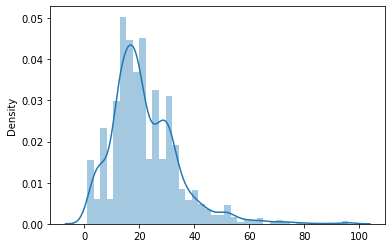

In [ ]:
def calculateMaxLen(dataset):
    max_len = 0
    lens = []
    for sample in dataset:
        l = len(sample)
        lens.append(l)
        if(l > max_len):
            max_len = l
    return max_len, lens

max_len, lens = calculateMaxLen(CBC_samples)
sns.distplot(lens)
max_length = 80 #This value is base on the length distribution, to avoid much filling later when padding

In [ ]:
CBC_samples = pad_sequences(CBC_samples, maxlen=max_length, padding='post', truncating='post')

In [ ]:
train_labels_true = CBC_labels
CBC_labels = to_categorical(CBC_labels, num_classes=5)

In [ ]:
embedding_dim = 256
epochs=300
learning_rate = 0.00001

In [ ]:
def createModel(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim))
  model.add(Dropout(0.25))
  model.add(LSTM(embedding_dim,
                 recurrent_initializer='glorot_uniform'))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
def createOptimizer(model):

  optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=1e-6)

  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics = ['accuracy'])
  return model

In [ ]:
model = createModel(vocab_size, embedding_dim)
model = createOptimizer(model)
model.summary()

print('File train loaded, shape:(%s, %s)' 
      %((len(CBC_samples), len(CBC_samples[0]))))
print('File train loaded, shape:(%s, %s)' 
      %((len(CBC_labels), len(CBC_labels[0]))))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         157952    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 684,549
Trainable params: 684,549
Non-trainable params: 0
_________________________________________________________________
File train loaded, shape:(2275, 80)
File train loaded, shape:(2275, 5)


In [ ]:
#keras.utils.plot_model(model, root_dir +'multi_input_and_output_model.png', show_shapes=True)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(CBC_samples, CBC_labels):
    x_train, x_test = CBC_samples[train_index], CBC_samples[test_index]
    y_train, y_test = CBC_labels[train_index], CBC_labels[test_index]
    train_labels_true = train_labels_true[test_index]

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, shuffle=True, verbose=2)

Epoch 1/300
57/57 - 27s - loss: 1.6100 - accuracy: 0.1962 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 2/300
57/57 - 24s - loss: 1.6097 - accuracy: 0.1951 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 3/300
57/57 - 24s - loss: 1.6097 - accuracy: 0.1967 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/300
57/57 - 24s - loss: 1.6096 - accuracy: 0.1962 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 5/300
57/57 - 24s - loss: 1.6096 - accuracy: 0.1912 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 6/300
57/57 - 25s - loss: 1.6096 - accuracy: 0.2005 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 7/300
57/57 - 24s - loss: 1.6096 - accuracy: 0.2132 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 8/300
57/57 - 26s - loss: 1.6094 - accuracy: 0.2110 - val_loss: 1.6094 - val_accuracy: 0.2066
Epoch 9/300
57/57 - 26s - loss: 1.6095 - accuracy: 0.1934 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 10/300
57/57 - 26s - loss: 1.6096 - accuracy: 0.1830 - val_loss: 1.6094 - val_accuracy: 0.2066

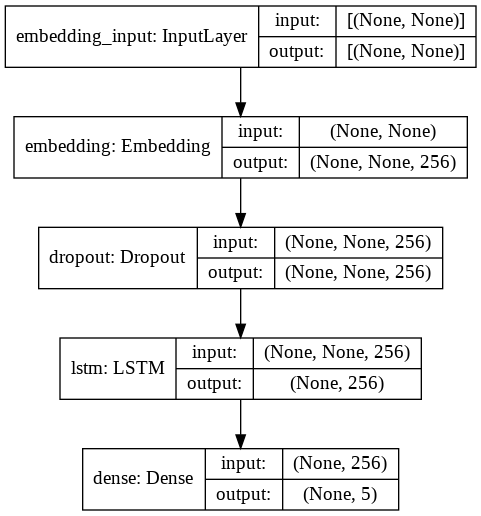

In [ ]:
keras.utils.plot_model(model, root_dir +'multi_input_and_output_model.png', show_shapes=True)

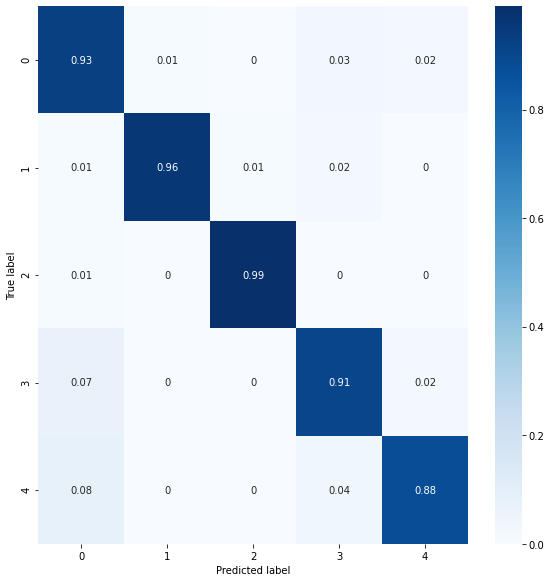

In [ ]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels=train_labels_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = range(0,5), columns = range(0,5))

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

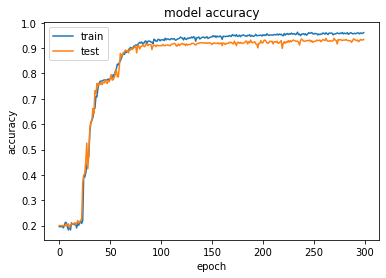

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

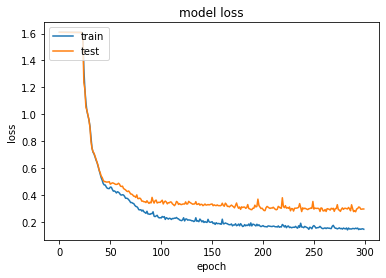

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()